# The Classiq Workflow

This notebook introduces the typical workflow with Classiq:
- **Designing a quantum algorithm** using the Qmod language and it's accompanied function library.
- **Synthesizing the algorithm** into a concrete circuit implementation.
- **Executing the algorithm** on a chosen simulator or quantum harware.
- **Post-processing** the results.

To get started, run:

In [10]:
from classiq import *

/Users/drorsegman/Library/Caches/pypoetry/virtualenvs/external-user-venv-PaJZMdG0-py3.11/lib/python3.11/site-packages/classiq/_internals/authentication/token_manager.py:101: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


If this `import` doesn't work for you, please try `pip install classiq` in your terminal, or refer to [Registration and Installation](https://docs.classiq.io/latest/classiq_101/registration_installations/).

## Designing a Quantum Algorithm



Here we will define a quantum function `main` that calculates a simple arithmetic expression.

Step-by-step:
1. Allocate 3 qbits for the quantum number `x`, allowing it to represent $2^3$ different numbers, from 0 to 7.
2. Apply `hadamard_transform` on `x` to prepare it into an equal superposition of all these numbers.
3. Assign the desired arithmetic expression result into the quantum number `y`.


In [11]:
@qfunc

def main(x: Output[QNum], y: Output[QNum]) -> None:
    allocate(3,x)
    hadamard_transform(x)
    y |= x**2 + 1


We expect the output variables `x` and `y` to end in an equal superpostion of the states $|x_i\rangle |y_i=x_i^2+1\rangle$ for $x_is$ from 0 to 7.
In other words, we have designed our quantum algorithm to calculate $x^2 +1$.

## Synthesizing the Algorithm

The function `main` describes your algorithm in a high-level manner: "calculate $x^2+1$ and assign in into `y`". However, it does not specify __how__ to apply this calculation - it does not map the desired result to an executable quantum circuit, made of elementary quantum gates.\
In order to do so, you can pass your algorithm to Classiq's synthesis engine. 

First, create a Quantum Model object `qmod` out of the function `main`:

In [15]:
qmod = create_model(main)

Then, pass `qmod` to the synthesis engine to obtain a concrete quantum program `qprog`.\
Note: here we'll use a simple call to the function `synthesize`. Later on in this tutorial, you will learn to provide configuration details (for example, which elementary gates are allowed to use?) using [`set_preferences`](https://docs.classiq.io/latest/sdk-reference/synthesis/?h=set_pre#classiq.set_preferences).

In [6]:
qprog = synthesize(qmod)

str

You can analyze the resulting implementation using Classiq visualization tool:

In [17]:
show(qprog)

Opening: https://platform.classiq.io/circuit/2sZn9mvqKtfZXcWLEN8U26r0kSj?version=0.67.0


You should see something like this:

![Screenshot 2025-02-04 at 14.51.53.png](<attachment:Screenshot 2025-02-04 at 14.51.53.png>)
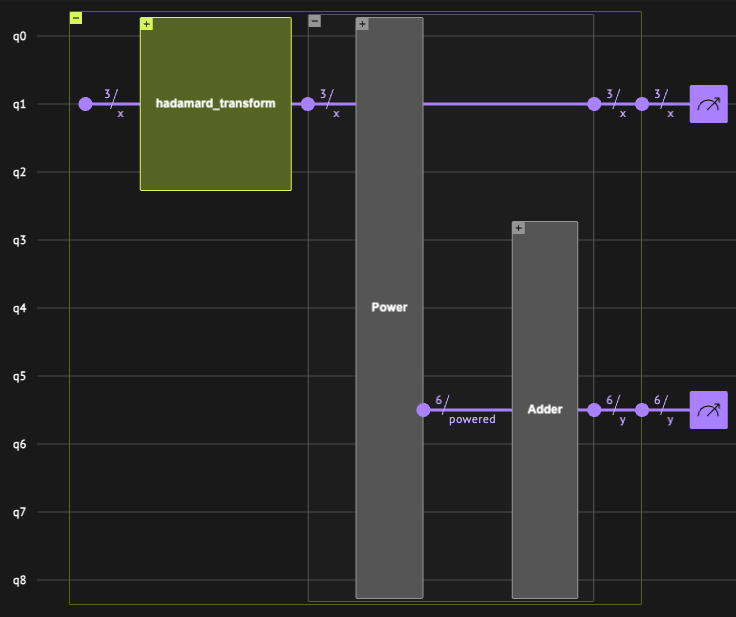

By clicking the `+` icons on the blocks' top-left corner, you can inspect the gate-level implementation of each functional block (for example, inspecting the complex combination of `H`, `CPHASE`, `CX` and `U` gates that implements the `Power` block.

## Practice
Edit the arithmetic expression inside `main`, using the `+`, `-`, `**` operators as well as literal numbers of your choice.\
Do the sampled states of `x` and `y` satsify your arithmetic expression?
